In [ ]:
# pip install imgaug

In [2]:
import random
import numpy as np
import os
import shutil
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from PIL import Image
import PIL.ImageOps
# imgaug의 시드 고정
ia.seed(42)

In [3]:
pwd

'C:\\Users\\user\\Desktop\\recognition_project'

In [4]:
%cd "./yolov5/archive"

C:\Users\user\Desktop\recognition_project\yolov5\archive


In [5]:
def route(t):
    file_path = os.path.join("./images", t)
    pth = []
    for f in os.listdir(file_path):
        pth.append(os.path.join(file_path, f))
    return pth
pth_tr = route("train")

In [6]:
def annot_route(t):
    file_path = os.path.join("./labels", t)
    pth = []
    for f in os.listdir(file_path):
        pth.append(os.path.join(file_path, f))
    return pth
annot_tr = annot_route("train")

### Data Augmentation 하기 전 파악해야 할 사항
- Rotation 
1. annotation 파일 저장 시에 정규화를 진행했는가?
    - 진행했음
    - affine transform 하기 전에 다시 복구 시켜서 진행할 것
    - x_center의 경우는 image의 width로 나눴다(image.size[0])
    - y_center의 경우는 image의 height로 나눴다(image.size[1])
2. x1, y1, x2, y2는 각각 어떤 것인가?
    - x1의 경우는 이미지의 x축의 좌측 끝, x2는 우측 끝
    - y1은 이미지의 y축의 가장 아래, y2는 가장 위

### Data Augmentation 대상
- class imbalance를 해결하기 위해서 Augmentation을 진행한다.
- annotation 中 1번 클래스가 상당 수를 차지하는 case에 대해서 augmentation을 진행한다

In [38]:
# class 파악
# 1번 클래스가 있는 경우는 무조건 다 augmentation의 대상이 된다.
# 확인 결과 4000장 중 749장의 경우가 augmentation의 대상이다.
# 각 사진 별로 3장씩 augmentation을 진행한다.
def classAnalysis(pth):
    l = []
    cnt = 0
    with open(pth, "r") as f:
        annots = f.readlines()
        for line in annots:
            if line[0] == '1':
                cnt += 1
            l.append(line[0])
    return cnt / len(l)
annot_pth = []
for idx in range(len(annot_tr)):
    ratio = classAnalysis(annot_tr[idx])
    if ratio > 0:
        annot_pth.append([annot_tr[idx], idx])

In [47]:
image_pth = []
for pth in annot_pth:
    imgs = pth_tr[pth[1]]
    image_pth.append(imgs)
image_pth

['./images\\train\\hard_hat_workers0.png',
 './images\\train\\hard_hat_workers1005.png',
 './images\\train\\hard_hat_workers1006.png',
 './images\\train\\hard_hat_workers1007.png',
 './images\\train\\hard_hat_workers101.png',
 './images\\train\\hard_hat_workers1010.png',
 './images\\train\\hard_hat_workers1013.png',
 './images\\train\\hard_hat_workers1014.png',
 './images\\train\\hard_hat_workers1017.png',
 './images\\train\\hard_hat_workers1018.png',
 './images\\train\\hard_hat_workers1024.png',
 './images\\train\\hard_hat_workers1034.png',
 './images\\train\\hard_hat_workers1035.png',
 './images\\train\\hard_hat_workers1038.png',
 './images\\train\\hard_hat_workers104.png',
 './images\\train\\hard_hat_workers1042.png',
 './images\\train\\hard_hat_workers1047.png',
 './images\\train\\hard_hat_workers1049.png',
 './images\\train\\hard_hat_workers1059.png',
 './images\\train\\hard_hat_workers1066.png',
 './images\\train\\hard_hat_workers1067.png',
 './images\\train\\hard_hat_workers1077

In [210]:
def make_noise(std, img):
    height, width, ch = img.shape
    # 각 channel에 적용
    # 하나 더 추가
    # 빈 배열 형성
    img_noise = np.zeros((height, width, ch), dtype = np.float)
    for i in range(height):
        for j in range(width):
            for k in range(ch):
                # gaussian distribution을 따르는 random 숫자를 넣는다
                mk_noise = np.random.normal()
                set_noise = std * mk_noise
                noise_input = img[i][j][k] + set_noise
                if noise_input > 255:
                    noise_input = 255
                if noise_input < 0:
                    noise_input = 255
                img_noise[i][j][k] = noise_input
    return img_noise

In [211]:
# 우선 첫 트라이는 height, width 역시도 그대로 그냥 두는 것이 아닌 crop된 사이즈에 맞게 처리를 하는 과정을 거쳐 본다.
def make_crop(img_annot, image):
    with open(img_annot, "r") as f:
        data = f.readlines()
        # cv2는 height, width, channel 순이다.
        img = image
        height, width = img.shape[0], img.shape[1]
        # 각 line에서 xmin, xmax, ymin, ymax를 뽑아낸다.
        xmin = []
        ymin = []
        xmax = []
        ymax = []
        xcenter = []
        ycenter = []
        new_xcenter = []
        new_ycenter = []
        WIDTH = []
        w_l = []
        HEIGHT = []
        h_l = []
        class_no = []
        for line in data:
            info = line.split()
            x_center, y_center, w, h = float(info[1]), float(info[2]), float(info[3]), float(info[4])
            class_no.append(int(line[0]))
            xcenter.append(int(x_center * width))
            ycenter.append(int(y_center * height))
            xmin.append(int((x_center - w/2) * width))
            ymin.append(int((y_center - h/2) * height))
            xmax.append(int((x_center + w/2) * width))
            ymax.append(int((y_center + h/2) * height))
            WIDTH.append(int(w * width))
            HEIGHT.append(int(h * height))
        xmin, ymin, xmax, ymax = min(xmin), min(ymin), max(xmax), max(ymax)
        # crop width
        crop_width = xmax - xmin
        crop_height = ymax - ymin
        for wid in WIDTH:
            w_l.append(wid/crop_width)
        for hei in HEIGHT:
            h_l.append(hei/crop_height)
        for x in xcenter:
            new_xcenter.append((x - xmin)/crop_width)
        for y in ycenter:
            new_ycenter.append((y - ymin)/crop_height)
    return xmin, ymin, xmax, ymax, xcenter, ycenter, new_xcenter, new_ycenter, w_l, h_l, class_no

In [212]:
# 한 사진당 3장의 augmentation을 적용
# 1. 사진을 rotation
# 2. noise 추가
# 3. CenterCrop을 진행한 후 resize. Resize의 경우는 추후에 코드를 돌릴 때, image size를 416으로 설정함으로써 진행한다.
# parameter 구성:
def data_augmentation(num, img, annot, n):
    image = cv2.imread(img)
    img_pth = img
    img_annot = annot
    # rotate
    if num == 0:
        # annotation file을 읽는다.
        f = open(img_annot)
        bbx = f.readlines()
        # normalize된 것을 복구하기 위한 작업
        d_w = image.shape[1] # 폭
        d_h = image.shape[0] # 높이
        # 하나씩 읽어온다.
        class_no = []
        for i in range(len(bbx)):
            bbxs = bbx[i].split(" ")
            for j in range(len(bbxs)):
                # 이는 class에 해당한다.
                if j == 0:
                    bbxs[j] = int(bbxs[j])
                    class_no.append(int(bbxs[j]))
                # str 형태를 float으로 바꿔온다
                else:
                    x = float(bbxs[j])
                    bbxs[j] = x
            # 대체하는 작업
            bbx[i] = bbxs
        # 작업해야할 bounding box
        bbx_new = []
        for i in range(len(bbx)):
            # 원래의 x_center
            x_center = bbx[i][1] * d_w
            # 원래의 y_center
            y_center = bbx[i][2] * d_h
            # 원래의 폭
            w = bbx[i][3] * d_w
            # 원래의 높이
            h = bbx[i][4] * d_h
            # x1, x2는 각각 boundingbox의 x좌표의 양 끝단
            # y1, y2는 각각 boundingbox의 y좌표의 양 끝단
            x1 = int(x_center - w/2)
            y1 = int(y_center - h/2)
            x2 = int(x_center + w/2)
            y2 = int(y_center + h/2)
            bbx_new.append([x1, y1, x2, y2])
        # 정규화 -> 원 상태
        # 여기에 이제 rotation을 적용
        # ia_bbxs는 우선 data augmentation을 적용시키기 위한 사전 작업
        ia_bbxs = []
        for b in bbx_new:
            ia_bbxs.append(BoundingBox(x1 = b[0], y1 = b[1], x2 = b[2], y2 = b[3]))
        bound_box = BoundingBoxesOnImage(ia_bbxs, shape = image.shape)
        # 180도 회전을 다음과 같이 진행한다.
        seq = iaa.Sequential([iaa.Affine(rotate = 180)])
        # 180도 회전 적용
        # Vertical Flip을 적용한다고 생각한다!
        img_aug, bbx_aug = seq(image = image, bounding_boxes = bound_box)
        # 이미지를 각 파일에 저장
        storage_dir = os.path.join(img_pth[:14], "rotation_"+str(n)+".png")
        cv2.imwrite(storage_dir, img_aug)
        # annotation file 역시 저장"
        # 똑같이 정규화를 시켜서 저장한다.
        annot_file_path = os.path.join(img_annot[:14], "rotation_"+str(n)+".txt")
        with open(annot_file_path, "w") as f:
            for a in range(len(bbx_aug)):
                class_id = class_no[a]
                # opencv의 경우는 높이, 폭, 채널 순서
                dx = 1/int(image.shape[1])
                dy = 1/int(image.shape[0])
                x1 = bbx_aug[a][0][0]
                x2 = bbx_aug[a][1][0]
                y1 = bbx_aug[a][0][1]
                y2 = bbx_aug[a][1][1]
                x_center = (x1+x2)/2 * dx
                y_center = (y1+y2)/2 * dy
                w = (x2-x1) * dx
                h = (y2-y1) * dy
                f.write(f"{class_id} {x_center:.5f} {y_center:.5f} {w:.5f} {h:.5f}\n")
    # Noise 추가
    # 기본적으로 noise로는 Gaussian noise를 추가한다.
    if num == 1:
        noise_img = make_noise(12, image)
        storage_dir = os.path.join(img_pth[:14], "noise_"+str(n)+".png")
        # 이미지 저장
        cv2.imwrite(storage_dir, noise_img)
        # annotation 저장
        new_annot_file_path = os.path.join(img_annot[:14], "noise_"+str(n)+".txt")
        original_annot_path = img_annot
        shutil.copyfile(original_annot_path, new_annot_file_path)
    # crop 진행.
    if num == 2:
        # Center 값만 변형 시킨다.
        # crop을 한다고 해서 Width와 height가 변하는 것은 아니다
        # 시작 기준점이 바뀐다. 일종의 좌표 변환을 진행한다고 생각한다.
        # annotation file이 들어가면서 시작
        # cv2는 height, width 순이다
        mk_annot = make_crop(img_annot, image)
        xmin, xmax, ymin, ymax = mk_annot[0], mk_annot[2], mk_annot[1], mk_annot[3]
        cropped_image = image[ymin:ymax, xmin:xmax]
        storage_dir = os.path.join(img_pth[:14], "cropped_"+str(n)+".png")
        cv2.imwrite(storage_dir, cropped_image)
        # annotation을 적어야 한다.
        annot_file_path = os.path.join(img_annot[:14], "cropped_"+str(n)+".txt")
        # new_xcenter, new_ycenter
        Xcenter = mk_annot[6]
        Ycenter = mk_annot[7]
        width_list = mk_annot[8]
        height_list = mk_annot[9]
        class_no = mk_annot[10]
        with open(annot_file_path, "w") as f:
            for idx in range(len(class_no)):
                class_id = class_no[idx]
                x_center = Xcenter[idx]
                y_center = Ycenter[idx]
                w = width_list[idx]
                h = height_list[idx]
                f.write(f"{class_id} {x_center:.5f} {y_center:.5f} {w:.5f} {h:.5f}\n")

In [214]:
for n in range(len(image_pth)):
    annot = annot_pth[n][0]
    imgs = image_pth[n]
    for num in range(3):
        data_augmentation(num, imgs, annot, n)

C:\Users\user\AppData\Local\Temp\ipykernel_9444\3718389932.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img_noise = np.zeros((height, width, ch), dtype = np.float)


In [166]:
# # Center 값만 변형 시킨다.
# # crop을 한다고 해서 Width와 height가 변하는 것은 아니다
# # 시작 기준점이 바뀐다. 일종의 좌표 변환을 진행한다고 생각한다.
# with open(annot_pth[156][0], "r") as f:
#     data = f.readlines()
#     img = cv2.imread(image_pth[156])
#     image1 = Image.open(image_pth[156])
#     height, width = img.shape[0], img.shape[1]
#     # 각 line에서 xmin, xmax, ymin, ymax를 뽑아낸다.
#     xmin = []
#     ymin = []
#     xmax = []
#     ymax = []
#     xcenter = []
#     ycenter = []
#     new_xcenter = []
#     new_ycenter = []
#     WIDTH = []
#     HEIGHT = []
#     for line in data:
#         info = line.split()
#         x_center, y_center, w, h = float(info[1]), float(info[2]), int(float(info[3]) * width), int(float(info[4]) * height)
#         WIDTH.append(int(w*width))
#         HEIGHT.append(int(h*height))
#         xcenter.append(int(x_center * width))
#         ycenter.append(int(y_center * height))
#         xmin.append(int((x_center - w/2) * width))
#         ymin.append(int((y_center - h/2) * height))
#         xmax.append(int((x_center + w/2) * width))
#         ymax.append(int((y_center + h/2) * height))
#     xmin, ymin, xmax, ymax = min(xmin), min(ymin), max(xmax), max(ymax)
#     for x in xcenter:
#         new_xcenter.append(x - xmin)
#     for y in ycenter:
#         new_ycenter.append(y - ymin)
    

124 140
52 67
46 60
125 69


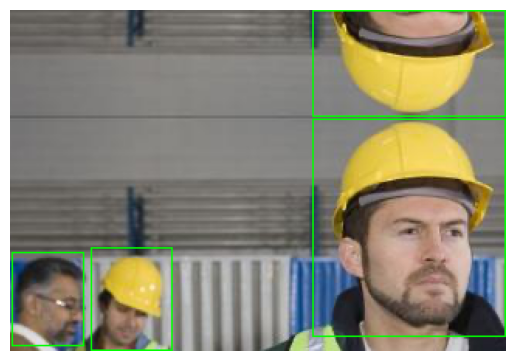

In [169]:
# import matplotlib.pyplot as plt
# for i in range(len(new_xcenter)):
#     x, y = new_xcenter[i], new_ycenter[i]
#     x1, y1, x2, y2 = xmin, ymin, xmax, ymax
#     w, h = wid[i], hei[i]
#     print(w, h)
#     cropped_image = img[y1:y2, x1:x2]
#     # 시각화
#     cv2.rectangle(cropped_image, (x - w//2, y - h//2), (x + w//2, y+h//2), (0, 255, 0), 1)
# plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
# plt.axis("off")
# plt.show()